# Exploring Run Results with MLFlow

In [25]:
import mlflow
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

from pathlib import Path

figure_directory = Path('../docs/assets/images/')

In [26]:
client = mlflow.MlflowClient('../mlruns')

experiment = client.search_experiments()[0]
experiment_id = experiment.experiment_id

parent_runs = client.search_runs(
    experiment_id, 
    "tags.mlflow.source.name='file:///workspaces/telfer-ecg-heartbeat-categorization-task'",
    order_by=["start_time"])

last_parent_run = parent_runs[-1]


## Early stopping visualization

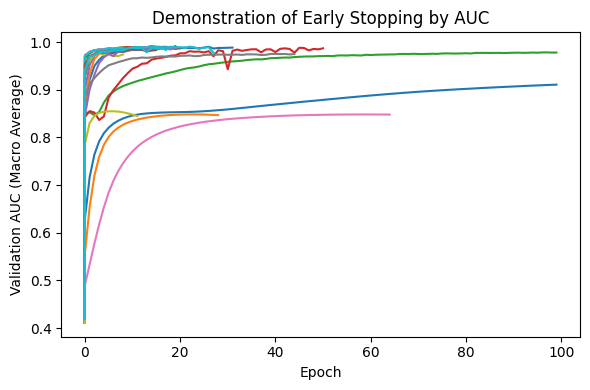

In [27]:

run_id = "2328622d8c974c95b3aaf7c12895828c"
runs = client.search_runs(
    [experiment_id],
    f"tags.mlflow.parentRunId='{last_parent_run.info.run_id}'",
)

plt.figure(figsize=(6,4))
for r in runs:
    history = client.get_metric_history(r.info.run_id, 'val_auroc')
    y = [i.value for i in history]
    x = [i.step for i in history]
    plt.plot(x, y, label=r.info.run_name)

plt.ylabel("Validation AUC (Macro Average)")
plt.xlabel("Epoch")
plt.title('Demonstration of Early Stopping by AUC')
plt.tight_layout()
plt.savefig(figure_directory / 'early_stopping_by_auc.png')

## Comparison between dataset results on all runs

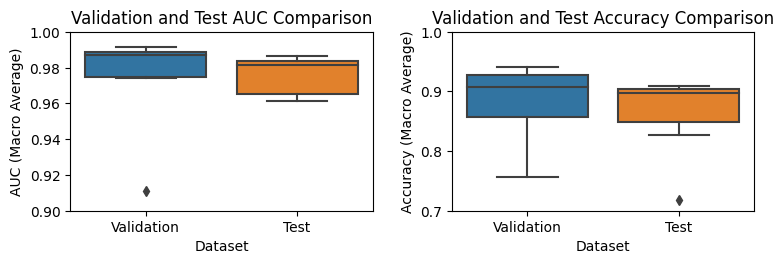

In [28]:
metrics_df = pd.DataFrame([r.data.metrics for r in runs])

def compare_datasets(df, col1_name, col2_name, ax=None):
    col1 = df[col1_name]
    col2 = df[col2_name]

    temp_df1 = pd.DataFrame(col1.values, columns=['Value'])
    temp_df1['Dataset'] = 'Validation'

    temp_df2 = pd.DataFrame(col2.values, columns=['Value'])
    temp_df2['Dataset'] = 'Test'

    temp_df = pd.concat([temp_df1, temp_df2], axis=0)
    sns.boxplot(data=temp_df, x='Dataset', y='Value', ax=ax)
    plt.tight_layout()

plt.figure(figsize=(8, 3))
gs = plt.GridSpec(1, 2)
ax = plt.subplot(gs[0])
compare_datasets(metrics_df, 'val_auroc', 'test_auroc', ax=ax)
plt.ylabel('AUC (Macro Average)')
plt.title('Validation and Test AUC Comparison')
plt.ylim([0.9, 1])

ax = plt.subplot(gs[1])
compare_datasets(metrics_df, 'val_accuracy', 'test_accuracy', ax=ax)
plt.ylabel('Accuracy (Macro Average)')
plt.title('Validation and Test Accuracy Comparison')
plt.tight_layout(pad=2.0)
plt.ylim([0.7, 1])
plt.savefig(figure_directory / "comparing_validation_vs_test_metrics.png")
plt.show()

## Best run parameters

In [30]:
params = ['weight_decay', 'lr', 'momentum', 'num_layers']

pd.Series({c: last_parent_run.data.tags[c] for c in params})


weight_decay    0.00013381067937488078
lr                0.005306323955804788
momentum            0.9695498105270768
num_layers                           4
dtype: object

## Best run comparison between dataset results

In [33]:
best_run_id = last_parent_run.data.tags['best_run']
best_run = client.get_run(best_run_id)

print('Train AUROC', best_run.data.metrics['train_auroc'])
print('Val AUROC', best_run.data.metrics['val_auroc'])
print('Test AUROC', best_run.data.metrics['test_auroc'])
print('Holdout AUROC', last_parent_run.data.tags['holdout_auroc'])

Train AUROC 0.9991170763969421
Val AUROC 0.9914817810058594
Test AUROC 0.9864406585693359
Holdout AUROC tensor(0.9833)
